In [17]:
!pip install arch

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed for reproducibility
np.random.seed(42)

# -----------------------
# 1. Download Data
# -----------------------
def fetch_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    data = data['Close'].dropna()
    data = pd.DataFrame(data)
    data.columns = ['Adj_Close']
    return data

# -----------------------
# 2. Preprocess Data
# -----------------------
def calculate_returns(data: pd.DataFrame) -> pd.Series:
    log_returns = np.log(data['Adj_Close'] / data['Adj_Close'].shift(1)).dropna()
    return log_returns

# -----------------------
# 3. Train-Test Split
# -----------------------
def split_data(returns: pd.Series, split_ratio=0.8):
    split_index = int(len(returns) * split_ratio)
    train, test = returns[:split_index], returns[split_index:]
    return train, test

# -----------------------
# 4. Fit GARCH Model
# -----------------------
def fit_garch_model(train_data: pd.Series):
    #model = arch_model(train_data*100, vol='GARCH', p=2, q=1, mean='Zero', dist='t')
    model = arch_model(train_data * 100, vol='GARCH', p=1, o=1, q=1, mean='Zero', dist='t')
    model_fit = model.fit(disp='off')
    return model_fit

# -----------------------
# 5. Forecast
# -----------------------
def forecast_volatility(model_fit, horizon: int):
    forecasts = model_fit.forecast(horizon=horizon, reindex=False)
    return forecasts.variance.values[-1]


def evaluate_model_no_rolling(model_fit, test_data: pd.Series, train_returns: pd.Series):
    # Get fitted volatility from training
    train_vol = np.sqrt(model_fit.conditional_volatility) / 100
    train_vol.index = train_returns.index

    # Forecast directly for the test horizon (no rolling)
    horizon = len(test_data)
    forecasts = model_fit.forecast(horizon=horizon, reindex=False)

    # Extract predicted variance → volatility
    pred_var = forecasts.variance.values[-1]  # last row has horizon forecasts
    pred_vol = np.sqrt(pred_var) / 100
    pred_vol = pd.Series(pred_vol, index=test_data.index)

    # For evaluation against realized volatility
    actual_vol_test = test_data.rolling(window=21).std().dropna()
    eval_pred = pred_vol[-len(actual_vol_test):]

    rmse = np.sqrt(mean_squared_error(actual_vol_test, eval_pred))
    mae = mean_absolute_error(actual_vol_test, eval_pred)
    print(f"[No Rolling] RMSE: {rmse:.6f}, MAE: {mae:.6f}")

    return train_vol, pred_vol

def plot_volatility(dates, train_vol, test_vol, actual_vol, split_date):
    plt.figure(figsize=(13, 6))

    # Plot both train and test volatility
    plt.plot(dates, actual_vol, label='Actual Volatility', color='blue')
    plt.plot(train_vol.index, train_vol, label='GARCH Volatility (Train)', color='yellow')
    plt.plot(test_vol.index, test_vol, label='GARCH Volatility (Test)', color='red')

    # Vertical line for train-test split
    plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')

    plt.title('GARCH Estimated Volatility (Train and Test)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





In [19]:
from scipy.stats import t
from scipy.stats import chi2
import statsmodels.api as sm

def ljung_box_test(model_fit, lags=[10, 20, 30]):
    """
    Apply Ljung-Box test on standardized residuals and squared residuals
    for specified lags (default: 10, 20, 30).
    """
    std_resid = model_fit.resid / model_fit.conditional_volatility

    print("\n--- Ljung-Box Test on Standardized Residuals ---")
    lb_resid = sm.stats.acorr_ljungbox(std_resid.dropna(), lags=lags, return_df=True)
    print(lb_resid)

    print("\n--- Ljung-Box Test on Squared Standardized Residuals ---")
    lb_sq = sm.stats.acorr_ljungbox((std_resid**2).dropna(), lags=lags, return_df=True)
    print(lb_sq)

    return lb_resid, lb_sq


def compute_var_t(returns: pd.Series, predicted_vol: pd.Series, fitted_model, alpha=0.05) -> pd.Series:
    # Get degrees of freedom from the fitted GARCH model
    df = fitted_model.params['nu']

    # Compute the t-distribution quantile
    z_t = t.ppf(alpha, df)

    # Return the parametric VaR
    return predicted_vol * z_t
def backtest_var(returns: pd.Series, var_series: pd.Series) -> pd.DataFrame:
    aligned_returns = returns[-len(var_series):]
    violations = aligned_returns < var_series
    backtest_df = pd.DataFrame({
        'Return': aligned_returns,
        'VaR': var_series,
        'Violation': violations.astype(int)
    })
    return backtest_df


def plot_var_backtest(backtest_df: pd.DataFrame, title: str):
    """Plot returns and VaR with violations highlighted"""
    plt.figure(figsize=(13, 6))
    plt.plot(backtest_df.index, backtest_df['Return'], label='Actual Return', alpha=0.7)
    plt.plot(backtest_df.index, backtest_df['VaR'], label='VaR (5%)', color='red', linestyle='--')
    plt.fill_between(backtest_df.index, backtest_df['VaR'], backtest_df['Return'],
                     where=backtest_df['Violation'], color='red', alpha=0.3, label='Violations')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def kupiec_pof_test(violations: pd.Series, alpha=0.05):
    n = len(violations)
    x = violations.sum()
    pi_hat = x / n

    if pi_hat in [0, 1]:
        return np.nan, np.nan  # Avoid log(0)

    LR_pof = -2 * (np.log(((1 - alpha) ** (n - x)) * (alpha ** x)) -
                   np.log(((1 - pi_hat) ** (n - x)) * (pi_hat ** x)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)

    print(f"--- Kupiec’s POF Test ---")
    print(f"Violations: {x}/{n}, Observed α̂: {pi_hat:.4f}, Expected α: {alpha}")
    print(f"POF Statistic: {LR_pof:.4f}, p-value: {p_value:.4f}")
    return LR_pof, p_value


def christoffersen_independence_test(violations: pd.Series):
    lagged = violations.shift(1).dropna()
    aligned = violations[1:]

    N00 = ((lagged == 0) & (aligned == 0)).sum()
    N01 = ((lagged == 0) & (aligned == 1)).sum()
    N10 = ((lagged == 1) & (aligned == 0)).sum()
    N11 = ((lagged == 1) & (aligned == 1)).sum()

    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0
    pi = (N01 + N11) / (N00 + N01 + N10 + N11)

    def safe_log(x): return np.log(x) if x > 0 else 0
    L0 = (N00 + N10) * safe_log(1 - pi) + (N01 + N11) * safe_log(pi)
    L1 = N00 * safe_log(1 - pi0) + N01 * safe_log(pi0) + \
         N10 * safe_log(1 - pi1) + N11 * safe_log(pi1)

    LR_ind = -2 * (L0 - L1)
    p_value = 1 - chi2.cdf(LR_ind, df=1)

    print(f"\n--- Christoffersen’s Independence Test ---")
    print(f"N00: {N00}, N01: {N01}, N10: {N10}, N11: {N11}")
    print(f"π0: {pi0:.4f}, π1: {pi1:.4f}")
    print(f"Independence LR Statistic: {LR_ind:.4f}, p-value: {p_value:.4f}")
    return LR_ind, p_value

def plot_qq_residuals(model_fit):
    # Standardized residuals = eps / sigma
    std_resid = model_fit.resid / model_fit.conditional_volatility
    df = model_fit.params['nu']
    fig, ax = plt.subplots(figsize=(13, 6))
    # Generate QQ-plot on the created axis
    sm.qqplot(std_resid, line='45', fit=True, dist=t, distargs=(df,), ax=ax)#student qq
    #sm.qqplot(std_resid, line='45', fit=True, ax=ax)# normal
    ax.set_title(f"QQ-Plot of Standardized Residuals vs Student's t(df={df:.2f})")# student
    #plt.title("QQ-Plot of Standardized Residuals")
    ax.grid(True)#student
    #plt.grid(True)
    plt.tight_layout()#studnet
    plt.show()


[*********************100%***********************]  1 of 1 completed


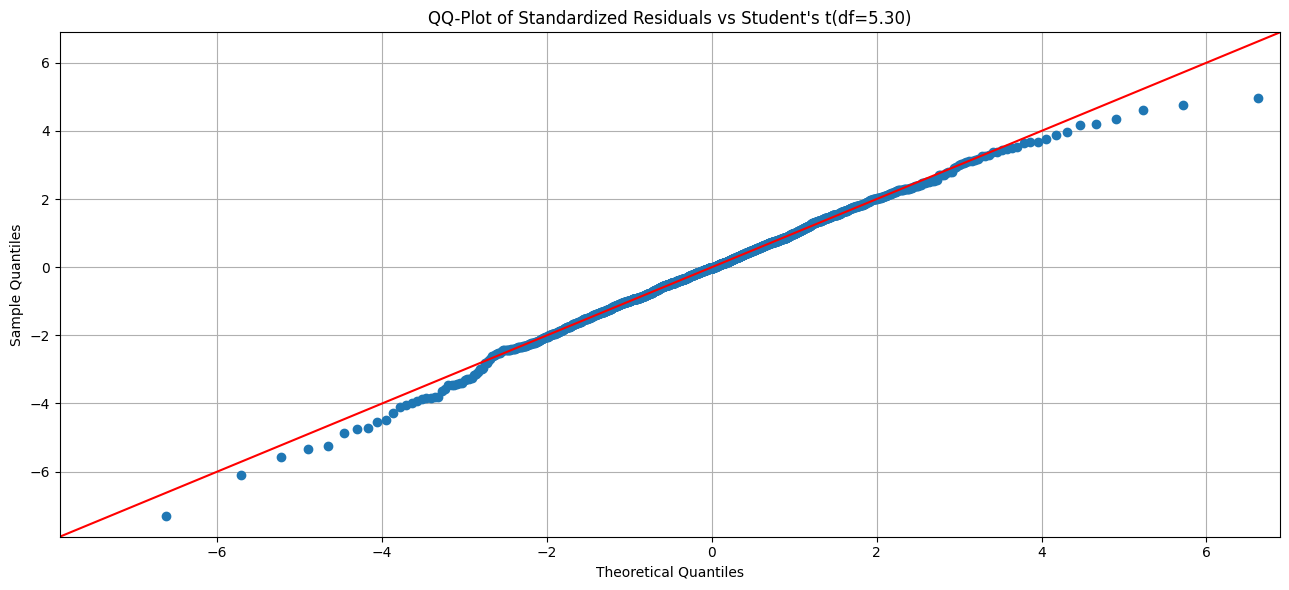


--- Ljung-Box Test on Standardized Residuals ---
      lb_stat  lb_pvalue
1    8.449016   0.003652
2    8.729843   0.012716
3    8.976442   0.029606
4   11.951540   0.017715
5   12.402844   0.029666
6   13.094347   0.041562
7   13.125478   0.069110
8   13.152031   0.106725
9   13.532779   0.139943
10  13.688029   0.187703
11  13.915705   0.237693
12  13.937711   0.304704
13  14.680274   0.327735
14  15.279507   0.359319
15  15.383157   0.424186
16  20.658128   0.192029
17  20.888806   0.231304
18  20.923287   0.283301
19  21.270705   0.322038
20  23.109838   0.283434
21  23.289002   0.328765
22  24.842613   0.304660
23  27.095163   0.251939
24  28.598417   0.235611
25  28.722452   0.275684
26  28.935284   0.314033
27  29.263559   0.348236
28  29.299531   0.397455
29  31.089880   0.361199
30  31.346060   0.398540

--- Ljung-Box Test on Squared Standardized Residuals ---
      lb_stat  lb_pvalue
1    0.027156   0.869110
2    0.174305   0.916537
3   17.905116   0.000460
4   18.039482   0

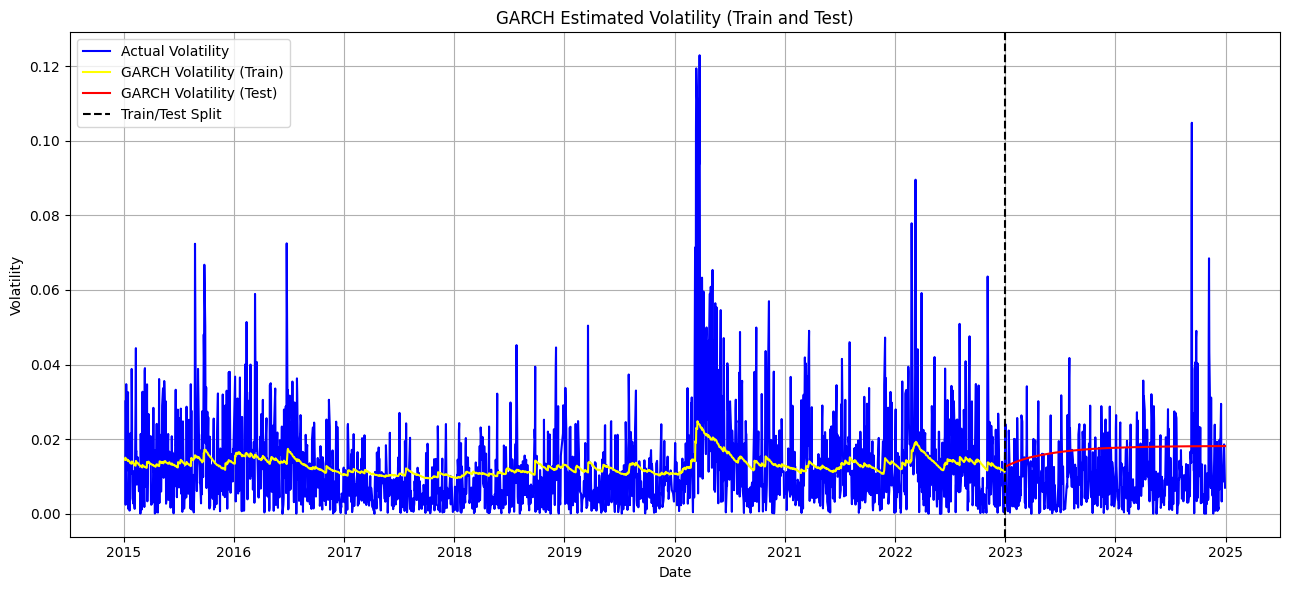

Train VaR Violations: 114 / 2032 (5.61%)


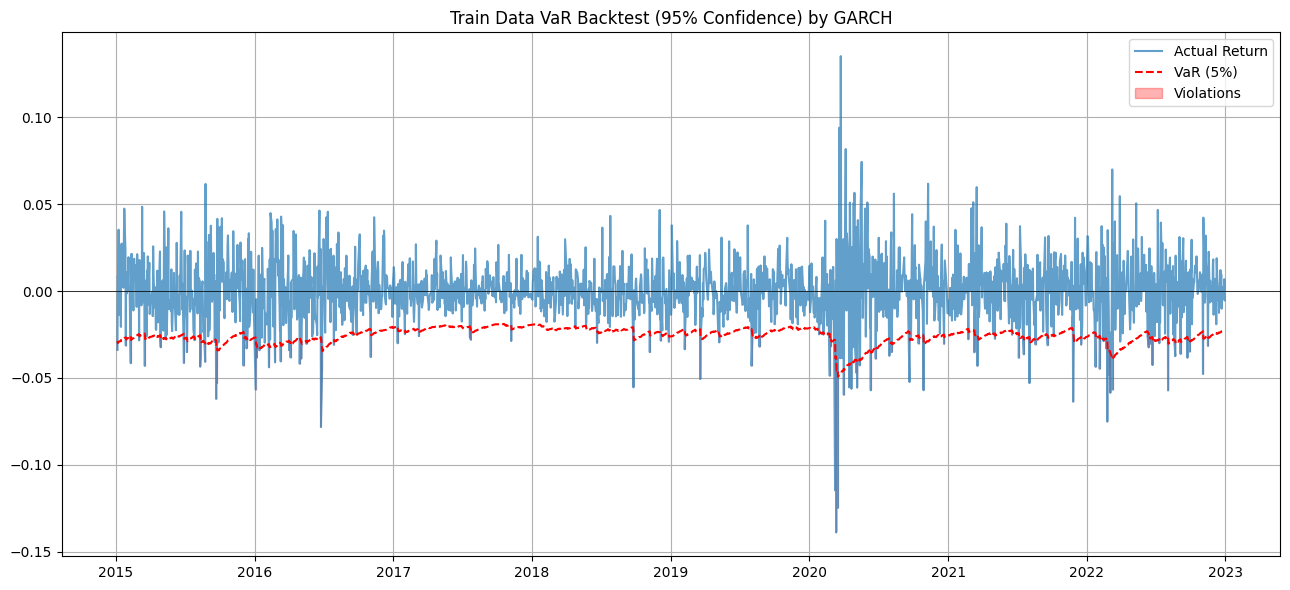

Test VaR Violations: 7 / 509 (1.38%)


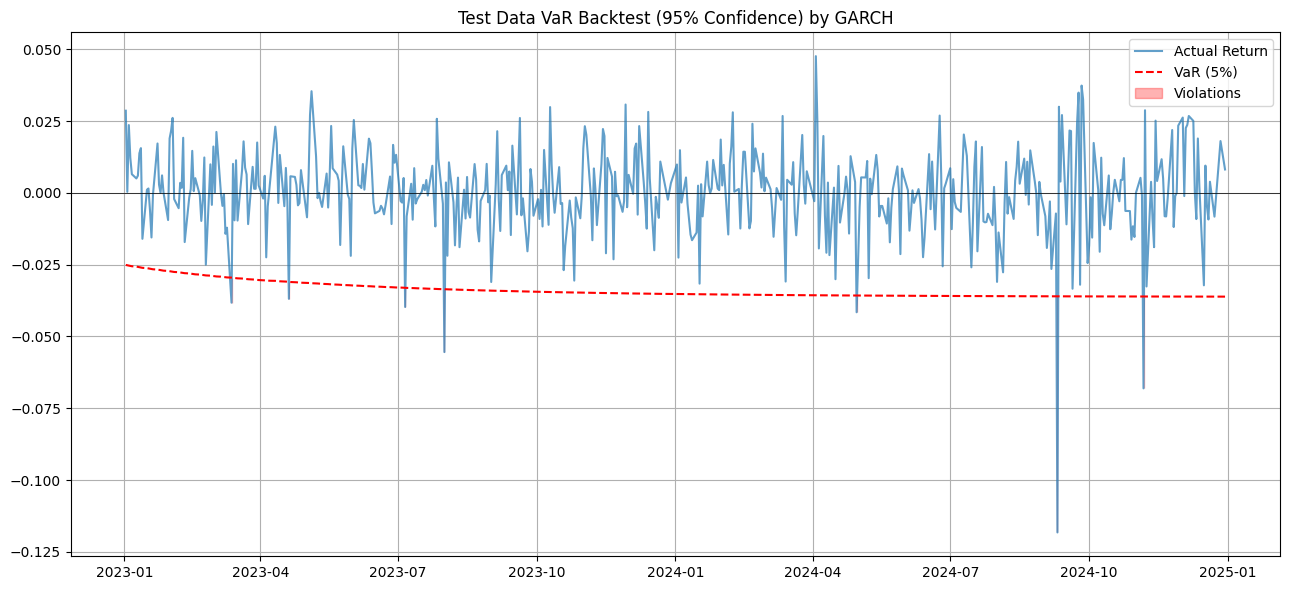


==== BACKTEST RESULTS: TEST SET ====
--- Kupiec’s POF Test ---
Violations: 7/509, Observed α̂: 0.0138, Expected α: 0.05
POF Statistic: 19.5239, p-value: 0.0000

--- Christoffersen’s Independence Test ---
N00: 494, N01: 7, N10: 7, N11: 0
π0: 0.0140, π1: 0.0000
Independence LR Statistic: 0.1956, p-value: 0.6583

==== BACKTEST RESULTS: TRAIN SET ====
--- Kupiec’s POF Test ---
Violations: 114/2032, Observed α̂: 0.0561, Expected α: 0.05
POF Statistic: 1.5351, p-value: 0.2153

--- Christoffersen’s Independence Test ---
N00: 1813, N01: 104, N10: 105, N11: 9
π0: 0.0543, π1: 0.0789
Independence LR Statistic: 1.1208, p-value: 0.2898


In [20]:
    if __name__ == "__main__":
      ticker = 'BMW.DE'
      start_date = '2015-01-01'
      end_date = '2024-12-31'

      # Step 1: Fetch data
      price_data = fetch_data(ticker, start=start_date, end=end_date)

      # Step 2: Compute log returns
      returns = calculate_returns(price_data)
      actual_vol = returns.rolling(window=2).std().dropna()

      # Step 3: Split data
      train_returns, test_returns = split_data(returns)

      # Step 4: Fit GARCH(2,1) with t-distribution
      garch_fit = fit_garch_model(train_returns)
      plot_qq_residuals(garch_fit)

      # Step 4: Fit GARCH(2,1) with t-distribution

      # 🔹 New Step: Ljung-Box test for diagnostics
      ljung_box_test(garch_fit, lags=30)


      # Step 5 & 6: Forecast and evaluate
      # Step 5 & 6: Forecast and evaluate (no rolling window)
      train_vol, test_vol = evaluate_model_no_rolling(garch_fit, test_returns, train_returns)

      # Step 7: Plot GARCH Volatility over both datasets
      split_date = test_returns.index[0]
      plot_volatility(actual_vol.index, train_vol, test_vol, actual_vol, split_date)

      # -------------------------------
      # Step 8: Backtest VaR (t-dist)
      # -------------------------------

      # Align returns
      aligned_returns = returns[train_vol.index[0]:]
      train_returns_bt = aligned_returns[:train_vol.index[-1]]

      # Training VaR and backtest
      train_var = compute_var_t(train_returns_bt, train_vol, garch_fit)
      train_bt = backtest_var(train_returns_bt, train_var)
      print(f"Train VaR Violations: {train_bt['Violation'].sum()} / {len(train_bt)} "
            f"({100 * train_bt['Violation'].mean():.2f}%)")
      plot_var_backtest(train_bt, "Train Data VaR Backtest (95% Confidence) by GARCH")

      # Test VaR and backtest
      test_returns_bt = returns[test_vol.index[0]:test_vol.index[-1]]
      test_var = compute_var_t(test_returns_bt, test_vol, garch_fit)  # ✅ FIXED: was compute_var
      test_bt = backtest_var(test_returns_bt, test_var)
      print(f"Test VaR Violations: {test_bt['Violation'].sum()} / {len(test_bt)} "
            f"({100 * test_bt['Violation'].mean():.2f}%)")
      plot_var_backtest(test_bt, "Test Data VaR Backtest (95% Confidence) by GARCH")

      # Statistical tests
      print("\n==== BACKTEST RESULTS: TEST SET ====")
      kupiec_pof_test(test_bt['Violation'], alpha=0.05)
      christoffersen_independence_test(test_bt['Violation'])

      print("\n==== BACKTEST RESULTS: TRAIN SET ====")
      kupiec_pof_test(train_bt['Violation'], alpha=0.05)
      christoffersen_independence_test(train_bt['Violation'])


In [21]:
from scipy.stats import t
from scipy.stats import chi2
import statsmodels.api as sm

def ljung_box_test(self, lags=30):
        """
        Perform Ljung-Box test on ARIMA residuals.
        lags: either an int L (will test lags 1..L) or an iterable of lags.
        Returns a pandas DataFrame (as returned by statsmodels.acorr_ljungbox).
        """
        if self.arima_model is None:
            raise ValueError("ARIMA model not trained. Run train_auto_arima() first.")
        # 1) try common places for residuals on pmdarima / statsmodels objects
        residuals = None
        # try callable resid() (some wrappers expose it)
        try:
            if callable(getattr(self.arima_model, "resid", None)):
                residuals = np.asarray(self.arima_model.resid()).ravel()
        except Exception:
            residuals = None

        # try attribute .resid
        if residuals is None:
            try:
                tmp = getattr(self.arima_model, "resid", None)
                if tmp is not None:
                    residuals = np.asarray(tmp).ravel()
            except Exception:
                residuals = None

        # fallback: compute residuals from in-sample predictions and self.train
        if residuals is None:
            # ensure we have training data
            if self.train is None:
                raise ValueError("Training data not available to compute residuals. Run train_auto_arima() first.")
            pred_in = np.asarray(self.arima_model.predict_in_sample())
            # align lengths: pred_in should be same length as self.train
            if len(pred_in) != len(self.train):
                # If lengths mismatch, trim/pad conservatively
                minlen = min(len(pred_in), len(self.train))
                pred_in = pred_in[-minlen:]
                train_vals = self.train.values[-minlen:]
                residuals = train_vals - pred_in
            else:
                residuals = self.train.values - pred_in

        residuals = np.asarray(residuals).ravel()

        # prepare lags list
        if isinstance(lags, int):
            # cannot test more lags than residuals-1
            max_possible = max(1, len(residuals) - 1)
            L = min(lags, max_possible)
            lags_list = list(range(1, L + 1))
        else:
            # assume iterable
            lags_list = list(lags)

        if len(lags_list) == 0:
            raise ValueError("No valid lags to test. Reduce requested lag or provide more data.")

        lb_test = acorr_ljungbox(residuals, lags=lags_list, return_df=True)
        print("\n=== Ljung-Box Test (H0: residuals are independently distributed) ===")
        print(lb_test)
        return lb_test



def compute_var_t(returns: pd.Series, predicted_vol: pd.Series, fitted_model, alpha=0.05) -> pd.Series:
    # Get degrees of freedom from the fitted GARCH model
    df = fitted_model.params['nu']

    # Compute the t-distribution quantile
    z_t = t.ppf(alpha, df)

    # Return the parametric VaR
    return predicted_vol * z_t
def backtest_var(returns: pd.Series, var_series: pd.Series) -> pd.DataFrame:
    aligned_returns = returns[-len(var_series):]
    violations = aligned_returns < var_series
    backtest_df = pd.DataFrame({
        'Return': aligned_returns,
        'VaR': var_series,
        'Violation': violations.astype(int)
    })
    return backtest_df


def plot_var_backtest(backtest_df: pd.DataFrame, title: str):
    """Plot returns and VaR with violations highlighted"""
    plt.figure(figsize=(13, 6))
    plt.plot(backtest_df.index, backtest_df['Return'], label='Actual Return', alpha=0.7)
    plt.plot(backtest_df.index, backtest_df['VaR'], label='VaR (5%)', color='red', linestyle='--')
    plt.fill_between(backtest_df.index, backtest_df['VaR'], backtest_df['Return'],
                     where=backtest_df['Violation'], color='red', alpha=0.3, label='Violations')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def kupiec_pof_test(violations: pd.Series, alpha=0.05):
    n = len(violations)
    x = violations.sum()
    pi_hat = x / n

    if pi_hat in [0, 1]:
        return np.nan, np.nan  # Avoid log(0)

    LR_pof = -2 * (np.log(((1 - alpha) ** (n - x)) * (alpha ** x)) -
                   np.log(((1 - pi_hat) ** (n - x)) * (pi_hat ** x)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)

    print(f"--- Kupiec’s POF Test ---")
    print(f"Violations: {x}/{n}, Observed α̂: {pi_hat:.4f}, Expected α: {alpha}")
    print(f"POF Statistic: {LR_pof:.4f}, p-value: {p_value:.4f}")
    return LR_pof, p_value


def christoffersen_independence_test(violations: pd.Series):
    lagged = violations.shift(1).dropna()
    aligned = violations[1:]

    N00 = ((lagged == 0) & (aligned == 0)).sum()
    N01 = ((lagged == 0) & (aligned == 1)).sum()
    N10 = ((lagged == 1) & (aligned == 0)).sum()
    N11 = ((lagged == 1) & (aligned == 1)).sum()

    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0
    pi = (N01 + N11) / (N00 + N01 + N10 + N11)

    def safe_log(x): return np.log(x) if x > 0 else 0
    L0 = (N00 + N10) * safe_log(1 - pi) + (N01 + N11) * safe_log(pi)
    L1 = N00 * safe_log(1 - pi0) + N01 * safe_log(pi0) + \
         N10 * safe_log(1 - pi1) + N11 * safe_log(pi1)

    LR_ind = -2 * (L0 - L1)
    p_value = 1 - chi2.cdf(LR_ind, df=1)

    print(f"\n--- Christoffersen’s Independence Test ---")
    print(f"N00: {N00}, N01: {N01}, N10: {N10}, N11: {N11}")
    print(f"π0: {pi0:.4f}, π1: {pi1:.4f}")
    print(f"Independence LR Statistic: {LR_ind:.4f}, p-value: {p_value:.4f}")
    return LR_ind, p_value

def plot_qq_residuals(model_fit):
    # Standardized residuals = eps / sigma
    std_resid = model_fit.resid / model_fit.conditional_volatility
    df = model_fit.params['nu']
    fig, ax = plt.subplots(figsize=(13, 6))
    # Generate QQ-plot on the created axis
    sm.qqplot(std_resid, line='45', fit=True, dist=t, distargs=(df,), ax=ax)#student qq
    #sm.qqplot(std_resid, line='45', fit=True, ax=ax)# normal
    ax.set_title(f"QQ-Plot of Standardized Residuals vs Student's t(df={df:.2f})")# student
    #plt.title("QQ-Plot of Standardized Residuals")
    ax.grid(True)#student
    #plt.grid(True)
    plt.tight_layout()#studnet
    plt.show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM RMSE: 0.010054, MAE: 0.006990


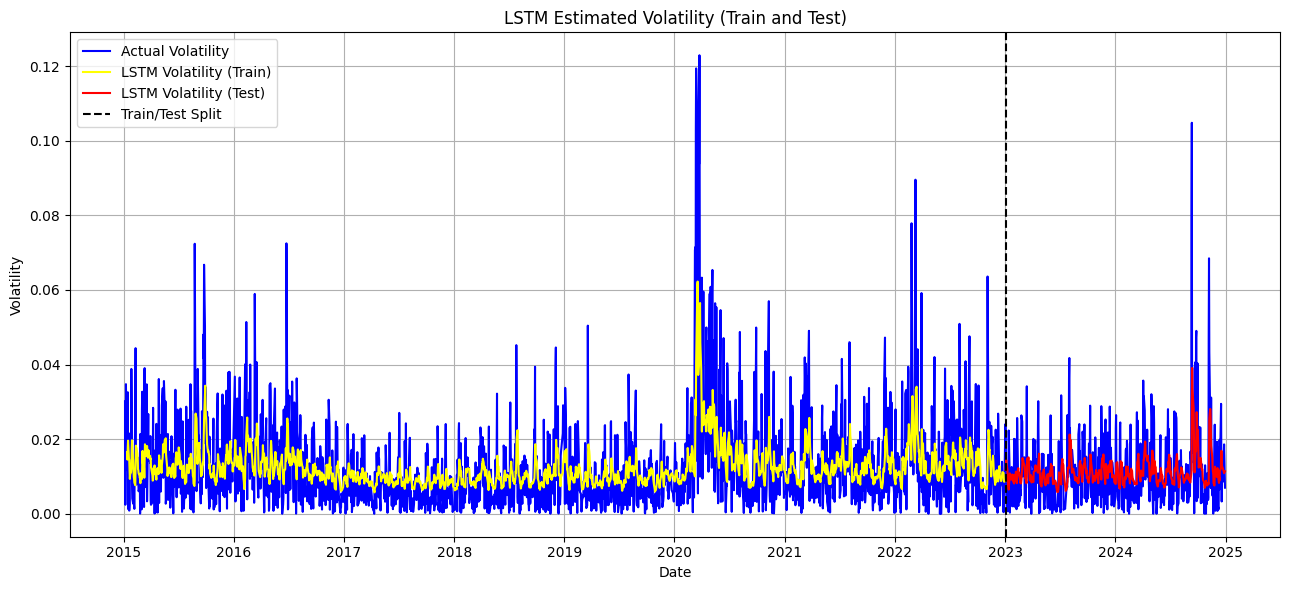


==== LJUNG-BOX TEST: TEST SET ====

--- Ljung-Box Test on Standardized Residuals ---
      lb_stat  lb_pvalue
10  11.748393   0.302249
20  20.859124   0.405466
30  31.155814   0.407776

--- Ljung-Box Test on Squared Standardized Residuals ---
     lb_stat  lb_pvalue
10  2.060662   0.995854
20  4.259697   0.999922
30  9.285938   0.999897

==== LJUNG-BOX TEST: TRAIN SET ====

--- Ljung-Box Test on Standardized Residuals ---
      lb_stat  lb_pvalue
10   8.813302   0.549909
20  21.940458   0.343750
30  30.499589   0.440294

--- Ljung-Box Test on Squared Standardized Residuals ---
      lb_stat  lb_pvalue
10  21.252079   0.019403
20  28.653944   0.094800
30  40.497431   0.095584


In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Set random seed for reproducibility
np.random.seed(42)

# -----------------------
# 1. Download Data
# -----------------------
def fetch_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    data = data['Close'].dropna()
    data = pd.DataFrame(data)
    data.columns = ['Adj_Close']
    return data

# -----------------------
# 2. Preprocess Data
# -----------------------
def calculate_returns(data: pd.DataFrame) -> pd.Series:
    log_returns = np.log(data['Adj_Close'] / data['Adj_Close'].shift(1)).dropna()
    return log_returns

def calculate_rolling_volatility(returns: pd.Series, window: int = 2) -> pd.Series:
    return returns.rolling(window=window).std().dropna()

# -----------------------
# 3. Train-Test Split
# -----------------------
def split_data(data: pd.Series, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train, test = data[:split_index], data[split_index:]
    return train, test

# -----------------------
# 4. Prepare Data for LSTM
# -----------------------
def prepare_lstm_data(series, window_size):
    X, y = [], []
    for i in range(window_size, len(series)):
        X.append(series[i-window_size:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# -----------------------
# 5. Build & Train LSTM Model
# -----------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
def ljung_box_test_lstm(returns: pd.Series, pred_vol: pd.Series, lags=[10, 20, 30]):
    """
    Ljung-Box test for LSTM residuals (standardized like in GARCH).
    Residuals = returns / predicted volatility
    """
    # Align returns and predicted volatility
    aligned_returns = returns.reindex(pred_vol.index).dropna()
    aligned_vol = pred_vol.reindex(aligned_returns.index)

    # Standardized residuals
    std_resid = aligned_returns / aligned_vol

    print("\n--- Ljung-Box Test on Standardized Residuals ---")
    lb_resid = sm.stats.acorr_ljungbox(std_resid, lags=lags, return_df=True)
    print(lb_resid)

    print("\n--- Ljung-Box Test on Squared Standardized Residuals ---")
    lb_sq = sm.stats.acorr_ljungbox(std_resid**2, lags=lags, return_df=True)
    print(lb_sq)

    return lb_resid, lb_sq


# -----------------------
# 6. Plotting
# -----------------------
def plot_volatility(dates, train_vol, test_vol, actual_vol, split_date):
    plt.figure(figsize=(13, 6))
    plt.plot(dates, actual_vol, label='Actual Volatility', color='blue')
    plt.plot(train_vol.index, train_vol, label='LSTM Volatility (Train)', color='yellow')
    plt.plot(test_vol.index, test_vol, label='LSTM Volatility (Test)', color='red')
    plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')
    plt.title('LSTM Estimated Volatility (Train and Test)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------
# 7. Main Execution
# -----------------------
if __name__ == "__main__":
    ticker = 'BMW.DE'
    start_date = '2015-01-01'
    end_date = '2024-12-31'

    # Step 1: Fetch and preprocess
    price_data = fetch_data(ticker, start=start_date, end=end_date)
    returns = calculate_returns(price_data)
    actual_vol = calculate_rolling_volatility(returns)

    # Step 2: Align returns and volatility
    returns = returns[actual_vol.index]  # align dates
    train_vol, test_vol_actual = split_data(actual_vol)
    split_date = test_vol_actual.index[0]

    # Step 3: Normalize data
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_vol.values.reshape(-1, 1))
    scaled_test = scaler.transform(test_vol_actual.values.reshape(-1, 1))

    # Step 4: Prepare LSTM inputs
    window_size = 5
    X_train, y_train = prepare_lstm_data(scaled_train, window_size)
    X_test, y_test = prepare_lstm_data(np.concatenate((scaled_train[-window_size:], scaled_test)), window_size)

    # Reshape for LSTM: [samples, time_steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Step 5: Build and train model
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=6, batch_size=48, verbose=0)

    # Step 6: Predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Step 7: Inverse scale
    train_vol_pred = scaler.inverse_transform(train_preds).flatten()
    test_vol_pred = scaler.inverse_transform(test_preds).flatten()

    # Align predictions with dates
    train_vol_pred_series = pd.Series(train_vol_pred, index=train_vol.index[window_size:])
    test_vol_pred_series = pd.Series(test_vol_pred, index=test_vol_actual.index)

    # Step 8: Evaluate
    eval_actual = test_vol_actual[-len(test_vol_pred_series):]
    rmse = np.sqrt(mean_squared_error(eval_actual, test_vol_pred_series))
    mae = mean_absolute_error(eval_actual, test_vol_pred_series)
    print(f"LSTM RMSE: {rmse:.6f}, MAE: {mae:.6f}")

    # Step 9: Plot
    plot_volatility(actual_vol.index, train_vol_pred_series, test_vol_pred_series, actual_vol, split_date)
    # Step 10: QQ-plot of residuals

    # === Add Ljung-Box Test for Test Set ===
    print("\n==== LJUNG-BOX TEST: TEST SET ====")
    ljung_box_test_lstm(returns[-len(test_vol_pred_series):], test_vol_pred_series)



    # === Add Ljung-Box Test for Train Set ===
    print("\n==== LJUNG-BOX TEST: TRAIN SET ====")
    ljung_box_test_lstm(returns[:len(train_vol_pred_series)], train_vol_pred_series)


In [23]:
from scipy.stats import t

def compute_var(returns: pd.Series, predicted_vol: pd.Series, alpha=0.05, df: int = 5) -> pd.Series:
    """
    Computes one-day ahead parametric VaR assuming Student's t-distributed residuals.

    Parameters:
        returns: series of actual returns
        predicted_vol: forecasted standard deviation from LSTM
        alpha: significance level (e.g. 0.05 for 95% VaR)
        df: degrees of freedom for t-distribution
    """
    z = t.ppf(alpha, df)
    return predicted_vol * z  # μ assumed ~0 for short-term returns

def backtest_var(returns: pd.Series, var_series: pd.Series) -> pd.DataFrame:
    """Checks how often actual return < VaR (i.e., VaR violation)"""
    aligned_returns = returns[-len(var_series):]
    violations = aligned_returns < var_series
    backtest_df = pd.DataFrame({
        'Return': aligned_returns,
        'VaR': var_series,
        'Violation': violations
    })
    return backtest_df

def plot_var_backtest(backtest_df: pd.DataFrame, title: str):
    """Plots return and VaR, marking violations"""
    plt.figure(figsize=(13, 5))
    plt.plot(backtest_df.index, backtest_df['Return'], label='Actual Return', alpha=0.7)
    plt.plot(backtest_df.index, backtest_df['VaR'], label='VaR (5%)', color='red', linestyle='--')
    plt.fill_between(backtest_df.index, backtest_df['VaR'], backtest_df['Return'],
                     where=backtest_df['Violation'], color='red', alpha=0.3, label='Violations')
    plt.title(title)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def kupiec_pof_test(violations: pd.Series, alpha=0.05):
    n = len(violations)
    x = violations.sum()
    pi_hat = x / n

    if pi_hat in [0, 1]:
        return np.nan, np.nan  # Avoid log(0)

    LR_pof = -2 * (np.log(((1 - alpha) ** (n - x)) * (alpha ** x)) -
                   np.log(((1 - pi_hat) ** (n - x)) * (pi_hat ** x)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)

    print(f"--- Kupiec’s POF Test ---")
    print(f"Violations: {x}/{n}, Observed α̂: {pi_hat:.4f}, Expected α: {alpha}")
    print(f"POF Statistic: {LR_pof:.4f}, p-value: {p_value:.4f}")
    return LR_pof, p_value


def christoffersen_independence_test(violations: pd.Series):
    lagged = violations.shift(1).dropna()
    aligned = violations[1:]

    N00 = ((lagged == 0) & (aligned == 0)).sum()
    N01 = ((lagged == 0) & (aligned == 1)).sum()
    N10 = ((lagged == 1) & (aligned == 0)).sum()
    N11 = ((lagged == 1) & (aligned == 1)).sum()

    pi0 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    pi1 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0
    pi = (N01 + N11) / (N00 + N01 + N10 + N11)

    def safe_log(x): return np.log(x) if x > 0 else 0
    L0 = (N00 + N10) * safe_log(1 - pi) + (N01 + N11) * safe_log(pi)
    L1 = N00 * safe_log(1 - pi0) + N01 * safe_log(pi0) + \
         N10 * safe_log(1 - pi1) + N11 * safe_log(pi1)

    LR_ind = -2 * (L0 - L1)
    p_value = 1 - chi2.cdf(LR_ind, df=1)

    print(f"\n--- Christoffersen’s Independence Test ---")
    print(f"N00: {N00}, N01: {N01}, N10: {N10}, N11: {N11}")
    print(f"π0: {pi0:.4f}, π1: {pi1:.4f}")
    print(f"Independence LR Statistic: {LR_ind:.4f}, p-value: {p_value:.4f}")
    return LR_ind, p_value
# def plot_qq_residuals_lstm(actual: pd.Series, predicted: pd.Series):
#     """
#     QQ-plot of residuals from LSTM volatility predictions.
#     """
#     # Residuals = actual - predicted
#     residuals = actual.loc[predicted.index] - predicted

#     fig, ax = plt.subplots(figsize=(13, 6))
#     sm.qqplot(residuals, line='45', fit=True, ax=ax)
#     plt.title("QQ-Plot of LSTM Volatility Residuals")
#     plt.grid(True)
#     plt.show()


def plot_qq_residuals_lstm(actual: pd.Series, predicted: pd.Series, dist_type="t"):
    """
    QQ-plot of residuals from LSTM volatility predictions.

    Parameters:
    - actual: pd.Series of actual volatility
    - predicted: pd.Series of predicted volatility
    - dist_type: "t" for Student's t QQ-plot, "normal" for Normal QQ-plot
    """
    # Residuals = actual - predicted
    residuals = actual.loc[predicted.index] - predicted

    fig, ax = plt.subplots(figsize=(13, 6))

    if dist_type == "t":
        # Estimate degrees of freedom for t-distribution from residuals
        # Method of moments: df = excess kurtosis-based approximation
        # If residuals are nearly normal, df will be large
        from scipy.stats import kurtosis
        excess_kurt = kurtosis(residuals, fisher=True)
        df_est = 6 / excess_kurt + 4 if excess_kurt > 0 else 30  # fallback for normal-ish data

        sm.qqplot(residuals, line='45', fit=True, dist=t, distargs=(df_est,), ax=ax)
        ax.set_title(f"QQ-Plot of LSTM Volatility Residuals vs Student's t(df≈{df_est:.2f})")

    else:  # Normal QQ-plot
        sm.qqplot(residuals, line='45', fit=True, ax=ax)
        ax.set_title("QQ-Plot of LSTM Volatility Residuals vs Normal")

    ax.grid(True)
    plt.tight_layout()
    plt.show()



Train VaR Violations: 134 out of 2027 (6.61%)


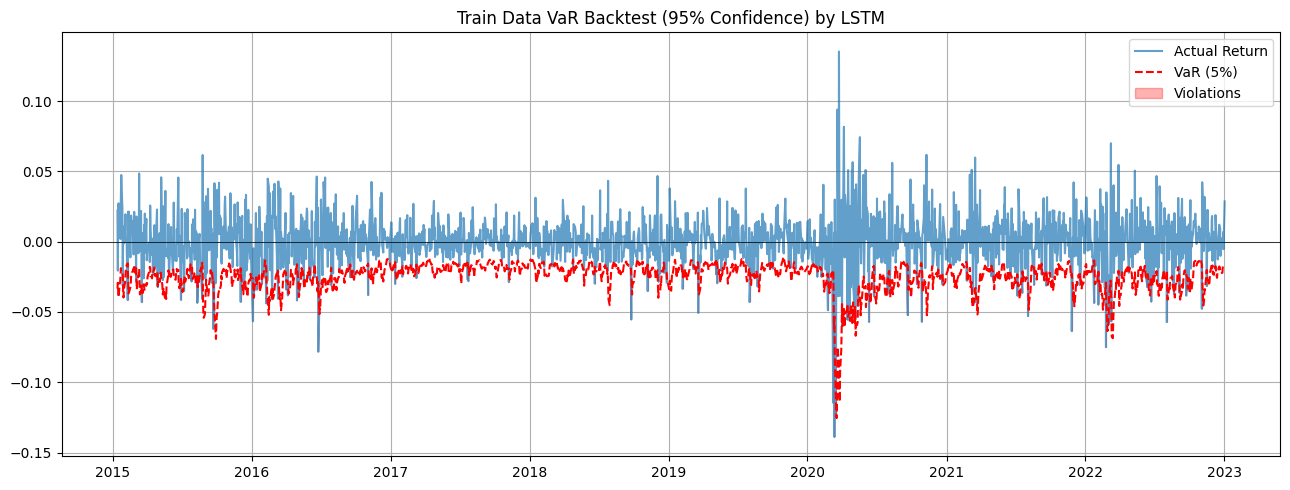

Test VaR Violations: 32 out of 508 (6.30%)


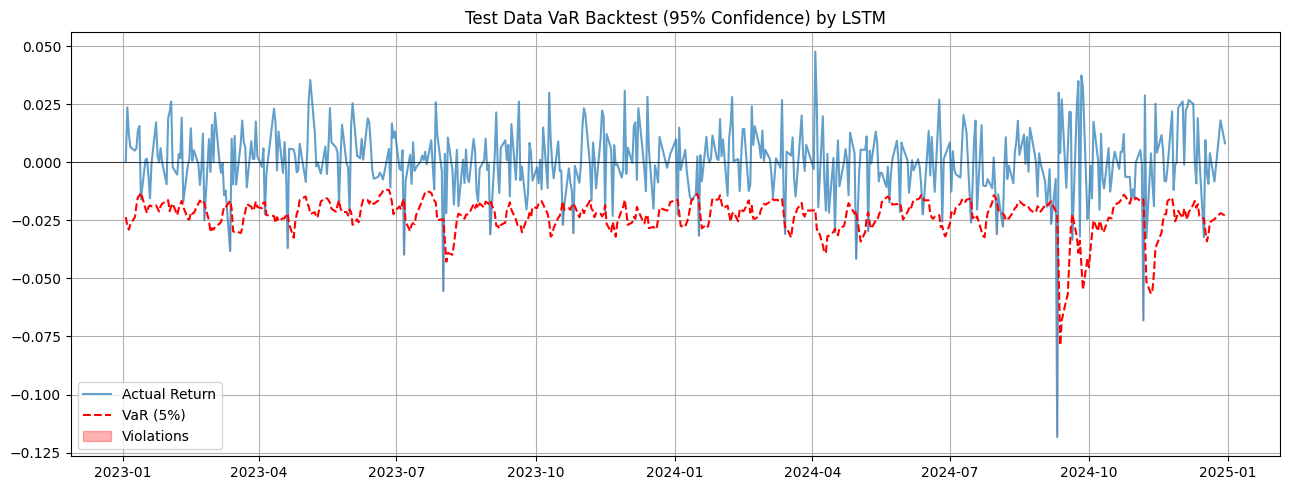


==== BACKTEST RESULTS: TEST SET ====
--- Kupiec’s POF Test ---
Violations: 32/508, Observed α̂: 0.0630, Expected α: 0.05
POF Statistic: 1.6738, p-value: 0.1957

--- Christoffersen’s Independence Test ---
N00: 443, N01: 32, N10: 32, N11: 0
π0: 0.0674, π1: 0.0000
Independence LR Statistic: 4.3148, p-value: 0.0378

==== BACKTEST RESULTS: TRAIN SET ====
--- Kupiec’s POF Test ---
Violations: 134/2027, Observed α̂: 0.0661, Expected α: 0.05
POF Statistic: 10.0984, p-value: 0.0015

--- Christoffersen’s Independence Test ---
N00: 1773, N01: 119, N10: 119, N11: 15
π0: 0.0629, π1: 0.1119
Independence LR Statistic: 4.1446, p-value: 0.0418


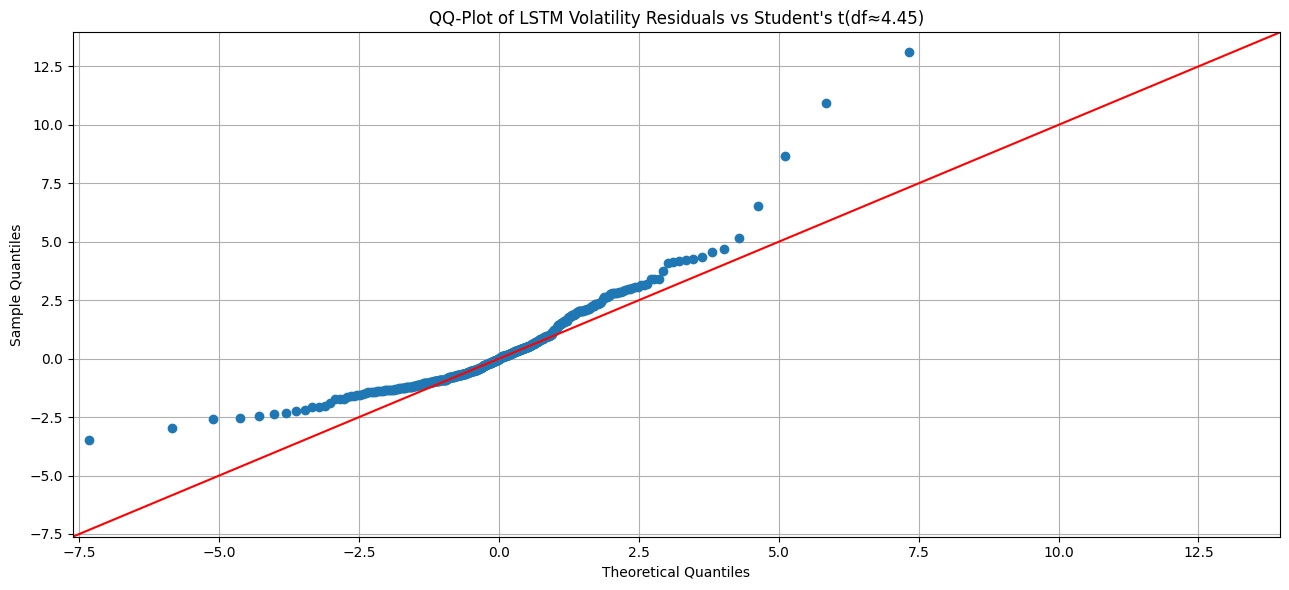

In [24]:
# Re-align returns
aligned_returns = returns[train_vol.index[window_size:][0]:]

# Training VaR
train_returns = aligned_returns[:train_vol_pred_series.index[-1]]
train_var = compute_var(train_returns, train_vol_pred_series, alpha=0.05, df=5)
train_bt = backtest_var(train_returns, train_var)
print(f"Train VaR Violations: {train_bt['Violation'].sum()} out of {len(train_bt)} "
      f"({100 * train_bt['Violation'].mean():.2f}%)")
plot_var_backtest(train_bt, title="Train Data VaR Backtest (95% Confidence) by LSTM")

# Testing VaR
test_returns = returns[test_vol_pred_series.index[0]:test_vol_pred_series.index[-1]]
test_var = compute_var(test_returns, test_vol_pred_series, alpha=0.05, df=5)
test_bt = backtest_var(test_returns, test_var)
print(f"Test VaR Violations: {test_bt['Violation'].sum()} out of {len(test_bt)} "
      f"({100 * test_bt['Violation'].mean():.2f}%)")
plot_var_backtest(test_bt, title="Test Data VaR Backtest (95% Confidence) by LSTM")
# === Add these after plot_var_backtest for test_bt ===

print("\n==== BACKTEST RESULTS: TEST SET ====")
kupiec_pof_test(test_bt['Violation'], alpha=0.05)
christoffersen_independence_test(test_bt['Violation'])

print("\n==== BACKTEST RESULTS: TRAIN SET ====")
kupiec_pof_test(train_bt['Violation'], alpha=0.05)
christoffersen_independence_test(train_bt['Violation'])
plot_qq_residuals_lstm(eval_actual, test_vol_pred_series)